<div class='heading'>
    <div style='float:left;'><h1>CPSC 4300/6300: Applied Data Science</h1></div>
    <img style="float: right; padding-right: 10px; width: 65px" src="https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/images/clemson_paw.png"> </div>


## Homework 4: Regression Modeling to Forecast Bike Sharing Usage

**Clemson University**<br>
**Fall 2021**<br>
**Instructor(s):** Nina Hubig <br>


---



In [ ]:
""" RUN THIS CELL TO GET THE RIGHT FORMATTING """
import requests
from IPython.core.display import HTML
css_file = 'https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/css/cpsc6300.css'
styles = requests.get(css_file).text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

<hr style="height:2pt">

<img src="https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/images/BSS.png">

### Overview 

You are hired by the administrators of the [Capital Bikeshare program](https://www.capitalbikeshare.com) program in Washington D.C., to **help them predict the hourly demand for rental bikes** and **give them suggestions on how to increase their revenue**. Your task is to prepare a short report summarizing your findings and make recommendations.

The predicted hourly demand could be used for planning the number of bikes that need to be available in the system at any given hour of the day. It costs the program money if bike stations are full and bikes cannot be returned, or empty and there are no bikes available. You will use multiple linear regression and polynomial regression and will explore ridge and lasso regression to predict bike usage. The goal is to build a regression model that can predict the total number of bike rentals in a given hour of the day, based on all available information given to you. 

An example of a suggestion to increase revenue might be to offer discounts during certain times of the day either during holidays or non-holidays. Your suggestions will depend on your observations of the seasonality of ridership.

The data for this problem were collected from the Capital Bikeshare program over the course of two years (2011 and 2012).



### Use only the libraries below:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score

from pandas.plotting import scatter_matrix

### Overview
The initial data set is provided in the file `data/BSS_hour_raw.csv`. You will first add features that will help with the analysis and then separate the data into training and test sets. Each row in this file represents the number of rides by registered users and casual users in a given hour of a specific date. There are 12 attributes in total describing besides the number of users the weather if it is a holiday or not etc: 


- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius, normalized)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius, normalized)
- `hum` (relative humidity, normalized)
- `windspeed` (wind speed, normalized)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)

---

<div class="theme">  Question 1 - Data Processing </div>

In this section, we read in the data and begin one of the most important analytic steps: verifying that the data is what it claims to be.

<div class="exercise"> <b> Question 1.1 </b> </div>

Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df_raw`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

In [149]:
# Your code here
bikes_df_raw = pd.read_csv('BSS_hour_raw.csv')
bikes_df_raw.head()
bikes_df_raw.shape

(17379, 13)

In [150]:
bikes_df_raw.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1


In [151]:
bikes_df_raw.describe()

,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869
std,1.106918,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000
50%,3.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000
75%,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000
max,4.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000


In [152]:
bikes_df_raw['season'].mean()

2.5016399102364923

In [153]:
print(bikes_df_raw.shape)
bikes_df_raw.columns

(17379, 13)


Index(['dteday', 'season', 'hour', 'holiday', 'weekday', 'workingday',
       'weather', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered'],
      dtype='object')

In [154]:
bikes_df_raw.dtypes

dteday         object
season          int64
hour            int64
holiday         int64
weekday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
dtype: object

In [155]:
print(np.sum([bikes_df_raw.dteday.isnull()]))
print(np.sum([bikes_df_raw.season.isnull()]))
print(np.sum([bikes_df_raw.hour.isnull()]))
print(np.sum([bikes_df_raw.holiday.isnull()]))
print(np.sum([bikes_df_raw.weekday.isnull()]))
print(np.sum([bikes_df_raw.workingday.isnull()]))
print(np.sum([bikes_df_raw.weather.isnull()]))
print(np.sum([bikes_df_raw.temp.isnull()]))
print(np.sum([bikes_df_raw.atemp.isnull()]))
print(np.sum([bikes_df_raw.hum.isnull()]))
print(np.sum([bikes_df_raw.windspeed.isnull()]))
print(np.sum([bikes_df_raw.casual.isnull()]))
print(np.sum([bikes_df_raw.registered.isnull()]))

0
0
0
0
0
0
0
0
0
0
0
0
0


*Your answer here*
There are no null values in the data. The values in 'temp' and 'atemp' are not in Celcius. As given in the overview, the temperature and apparent temperature should be in Celcius, but in the given dataset, they were not in Celcius.

<div class="exercise"> <b> Question 1.2 </b> </div>

Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

**Hint:** http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html

In [156]:
# Your code here
bikes_df_raw['dteday'] = pd.to_datetime(bikes_df_raw['dteday'])
bikes_df_raw['dteday'].head()

0   2011-01-01
1   2011-01-01
2   2011-01-01
3   2011-01-01
4   2011-01-01
Name: dteday, dtype: datetime64[ns]

<div class="exercise"> <b> Question 1.3 </b> </div>

Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that **hour** (this is the response variable for later).

In [157]:
# Your code here
bikes_df_raw["year"] = bikes_df_raw.dteday.dt.year
bikes_df_raw["month"] = bikes_df_raw.dteday.dt.year
bikes_df_raw["count"] = bikes_df_raw.casual + bikes_df_raw.registered
bikes_df_raw.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,year,month,count
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,2011,2011,16
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,2011,2011,40
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,2011,2011,32
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,2011,2011,13
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,2011,2011,1


---

<div class="theme">  Question 2 - Exploratory Data Analysis </div>

In this question we begin hunting for patterns in ridership that shed light on who uses the service and why.

<div class='exercise'> <b> Question 2.1 </b></div>

Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature
- `atemp`, the average atemp that day
- `windspeed`, the average windspeed that day
- `hum`, the average humidity that day
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

Name this dataframe `bikes_by_day`.

Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

**Hint:** helpful to use panda's `.groupby()` command

In [158]:
def mode_func(x):

    return x.value_counts().index[0]

bikes_by_day = bikes_df_raw.groupby('dteday').agg({'weekday': mode_func, 'weather': 'mean','season':'mean',
                                               'temp': 'mean', 'atemp': 'mean','windspeed':'mean',
                                               'hum': 'mean', 'casual': np.sum, 'registered': np.sum, 'count' : np.sum})
bikes_by_day = bikes_by_day.reset_index()
bikes_by_day.head()


,dteday,weekday,weather,season,temp,atemp,windspeed,hum,casual,registered,count
0,2011-01-01,6,1.583333,1,0.344167,0.363625,0.160446,0.805833,331,654,985
1,2011-01-02,0,1.956522,1,0.363478,0.353739,0.248539,0.696087,131,670,801
2,2011-01-03,1,1.000000,1,0.196364,0.189405,0.248309,0.437273,120,1229,1349
3,2011-01-04,2,1.043478,1,0.200000,0.212122,0.160296,0.590435,108,1454,1562
4,2011-01-05,3,1.000000,1,0.226957,0.229270,0.186900,0.436957,82,1518,1600


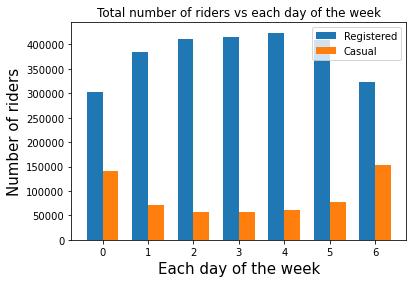

In [159]:
bikes_by_weekday=bikes_df_raw.groupby(["weekday"]).sum()
fig, ax = plt.subplots()
ax.bar(bikes_by_weekday.index - 0.35/2, bikes_by_weekday["registered"], 0.35, label='Registered')
ax.bar(bikes_by_weekday.index + 0.35/2, bikes_by_weekday["casual"], 0.35, label='Casual')
ax.set_title('Total number of riders vs each day of the week')
ax.set_ylabel(r'Number of riders', fontsize = 15)
ax.set_xlabel(r'Each day of the week', fontsize = 15)


ax.legend()

plt.show()

<div class='exercise'> <b> Question 2.2 </b></div>

Use `bikes_by_day` to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 

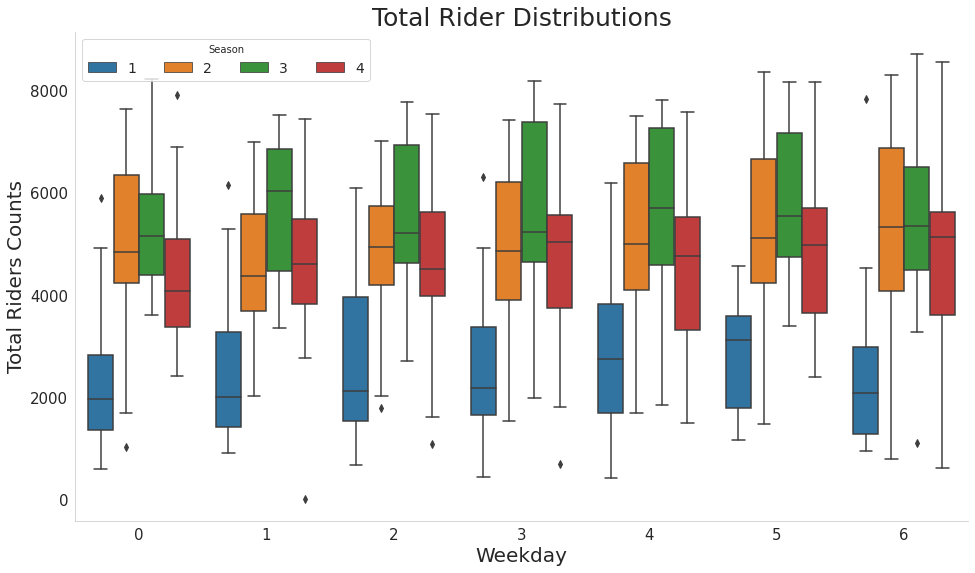

In [160]:
# Your code here
with sns.axes_style("whitegrid"):
# setup plot
    fig, ax = plt.subplots(figsize=(16,9))
    sb = sns.boxplot(x='weekday', y='count', hue='season', data=bikes_by_day, ax=ax)
# labels and such
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xlabel('Weekday', fontsize=20)
    ax.set_ylabel('Total Riders Counts', fontsize=20)
    ax.set_title('Total Rider Distributions', fontsize=25)
    ax.legend(title='Season', fontsize=14, ncol=4, loc='upper left')
    sns.despine()
    ax.grid(False)

*Your answer here*


<div class='exercise'> <b> Question 2.3 </b></div>

Convert the categorical attributes ('season', 'month', 'weekday', 'weather') into multiple binary attributes using **one-hot encoding** and call this new dataframe `bikes_df`.

In [161]:
# Your code here
bikes_df = bikes_df_raw.copy()
bikes_df.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,year,month,count
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,2011,2011,16
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,2011,2011,40
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,2011,2011,32
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,2011,2011,13
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,2011,2011,1


In [162]:
# Your code here
bikes_df= pd.get_dummies(bikes_df_raw, columns = ['season', 'month', 'weekday','weather'])
bikes_df.head()

,dteday,hour,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_1,weather_2,weather_3,weather_4
0,2011-01-01,0,0,0,0.24,0.2879,0.81,0.0,3,13,...,0,0,0,0,0,1,1,0,0,0
1,2011-01-01,1,0,0,0.22,0.2727,0.80,0.0,8,32,...,0,0,0,0,0,1,1,0,0,0
2,2011-01-01,2,0,0,0.22,0.2727,0.80,0.0,5,27,...,0,0,0,0,0,1,1,0,0,0
3,2011-01-01,3,0,0,0.24,0.2879,0.75,0.0,3,10,...,0,0,0,0,0,1,1,0,0,0
4,2011-01-01,4,0,0,0.24,0.2879,0.75,0.0,0,1,...,0,0,0,0,0,1,1,0,0,0


<div class='exercise'> <b> Question 2.4 </b></div>

Split the updated `bikes_df` dataset into a 50-50 train-test split (call them `bikes_train` and `bikes_test`, respectively). Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set.  Use `random_state=90`, a test set size of .5, and stratify on month.

In [179]:
# Your code here
try:
# stratification
    train_data, test_data = train_test_split(bikes_df_raw,random_state=90, test_size=0.5, stratify=bikes_df_raw['month'])
except:
# Count the missing lines and drop them
    missing_rows = np.isnan(bikes_df.month)
    print("{} lines miss data. Dropping them.".format(np.sum(missing_rows)))
    bikes_df = bikes_df_raw.dropna(subset=['month'])
    train_data, test_data = train_test_split(bikes_df,random_state=90, test_size=0.5, stratify=bikes_df['month'])

In [169]:
train_data.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,year,month,count
478,2011-01-21,1,23,0,5,1,1,0.06,0.0455,0.38,0.3284,0,27,2011,2011,27
15899,2012-10-31,4,4,0,3,1,2,0.30,0.2879,0.87,0.1940,0,5,2012,2012,5
17272,2012-12-27,1,13,0,4,1,1,0.30,0.2727,0.49,0.4627,19,99,2012,2012,118
14027,2012-08-12,3,16,0,0,0,1,0.76,0.6818,0.40,0.1045,213,300,2012,2012,513
13521,2012-07-22,3,14,0,0,0,1,0.72,0.6818,0.66,0.1045,256,360,2012,2012,616


<div class='exercise'> <b> Question 2.5 </b></div>

Although we asked you to create your train and test set, for consistency and easy checking, we ask that for the rest of this problem set you use the train and test set provided in the files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). 

In [170]:
# Your code here
BSS_train = pd.read_csv("BSS_train.csv")
display(BSS_train.columns)
BSS_test = pd.read_csv("BSS_test.csv")
display(BSS_test.columns)

Index(['dteday', 'hour', 'holiday', 'year', 'workingday', 'temp', 'atemp',
       'hum', 'windspeed', 'casual', 'registered', 'counts', 'spring',
       'summer', 'fall', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
       'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm'],
      dtype='object')

Index(['dteday', 'hour', 'holiday', 'year', 'workingday', 'temp', 'atemp',
       'hum', 'windspeed', 'casual', 'registered', 'counts', 'spring',
       'summer', 'fall', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
       'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm'],
      dtype='object')

In [171]:
col_drop = ['dteday', 'year', 'registered', 'casual']
BSS_train = BSS_train.drop(col_drop, axis=1)
BSS_test = BSS_test.drop(col_drop, axis=1)


<div class='exercise'> <b> Question 2.6 </b></div>

Use pandas' `scatter_matrix` command to visualize the inter-dependencies among the list of predictors listed below in the training dataset. Note and comment on any strongly related variables. [This may take a few minutes to run. You may wish to comment it out until your final submission, or only plot a randomly-selected 10% of the rows]

`cor_columns = ['hour', 'holiday', 'temp', 'atemp', 
               'workingday', 'hum', 'windspeed', 
               'counts', 'casual', 'registered',
               'fall', 'summer', 'spring', 
               'Snow', 'Storm', 'Cloudy']`

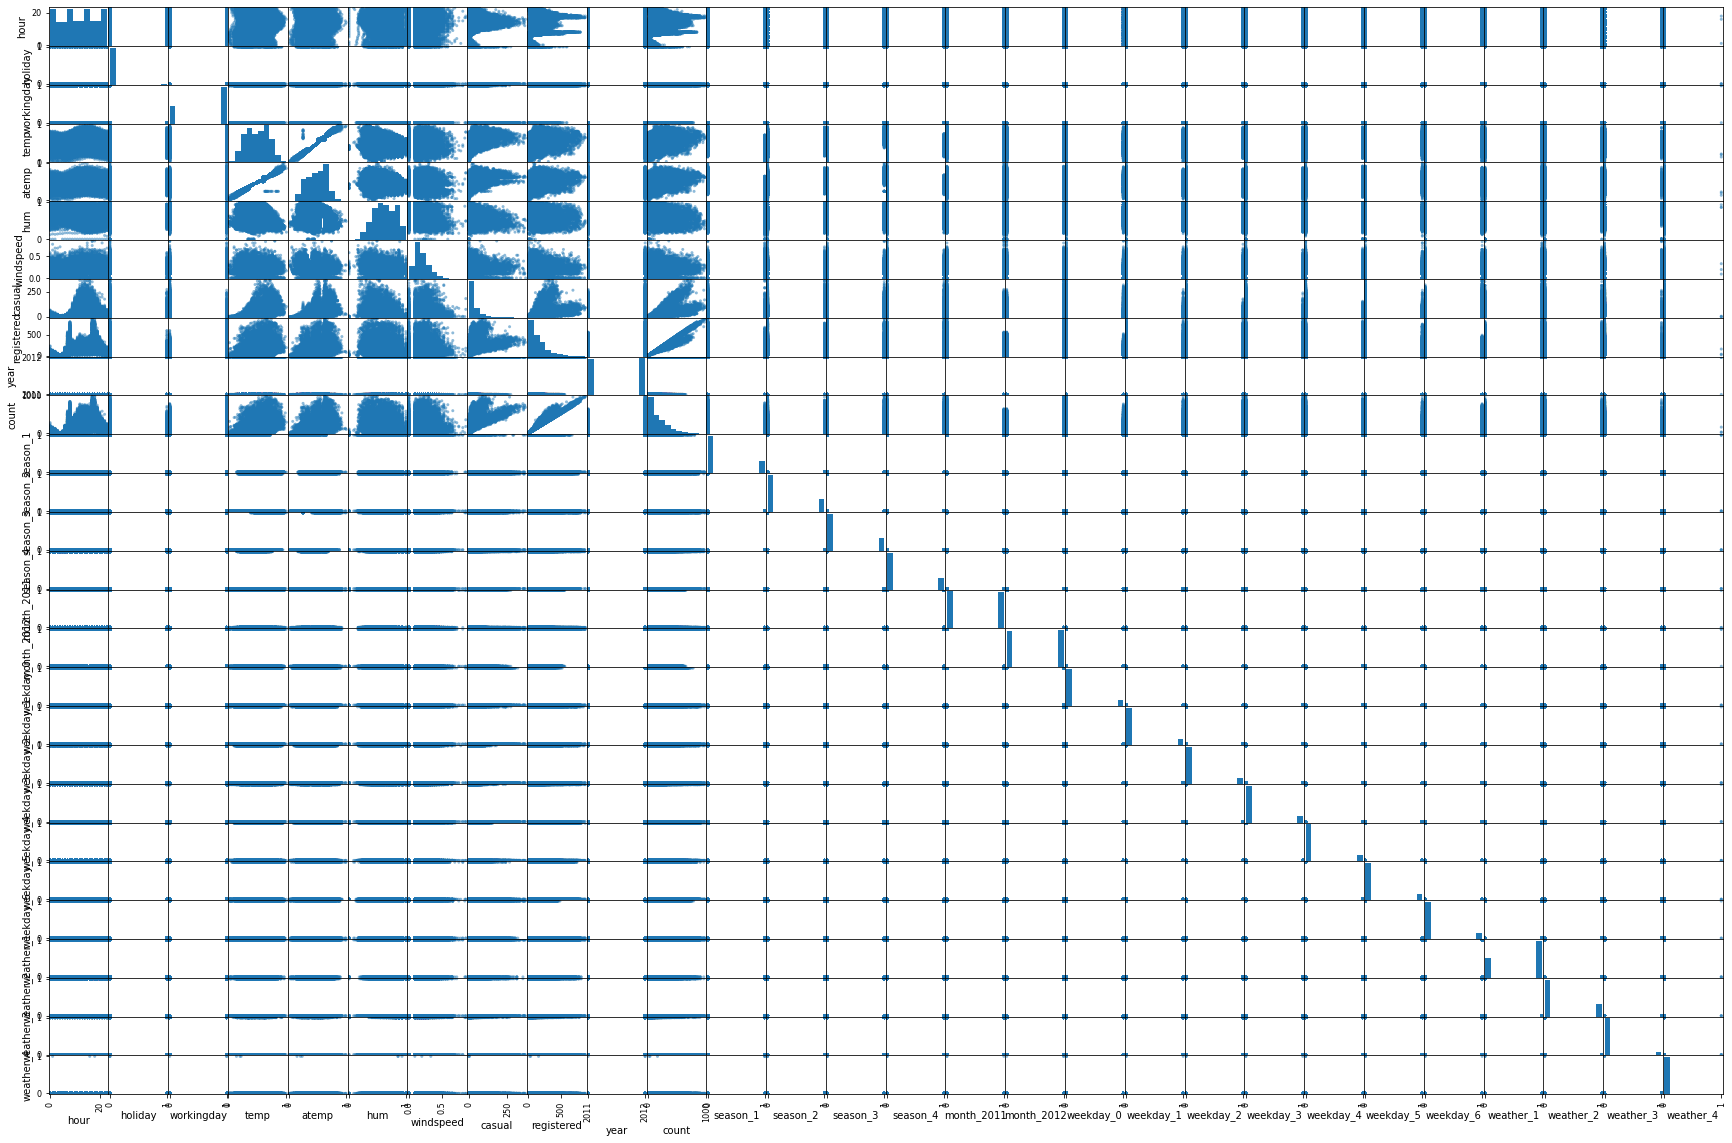

In [178]:
# Your code here
scatter_matrix(bikes_df, figsize=(30, 20));

## Answer
Temperature and apparent temperatures are related and also casual, registered, and count are also correlated



<div class='exercise'> <b> Question 2.7 </b></div>

Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe. 

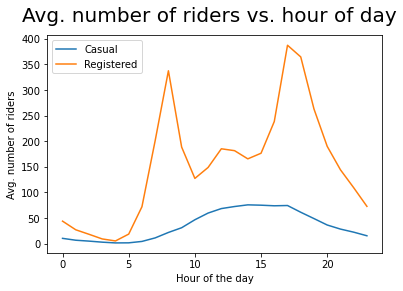

In [181]:
# Your code here
temp_df = bikes_df.groupby("hour").agg(['mean'])
# plotting casual riders
plt.plot(temp_df.index, temp_df.casual)
# plotting registered riders
plt.plot(temp_df.index, temp_df.registered)
# styling graph
plt.suptitle("Avg. number of riders vs. hour of day", size=20)
plt.ylabel("Avg. number of riders")
plt.xlabel("Hour of the day")
plt.legend(["Casual", "Registered"]);

## Answer
From the plot, we can see that the registered users have more riders when compared to casual users.

Starting from 5:00 Am there is a dramatic increase of rides by registered users till 10:00 Am. Then the number of rides is dipped to 130 rides from 325 rides at the end of 10:00 Am. After 10:00 Am there are some fluctuations till 15:00 pm, then a sudden increase in the number of riders happened after 16:00 Pm and reached the peak of 380 average riders and gradually decreased by the end of the day.

For casual users, the average number of rides is less than 40 from (0-10) hours, then there is a gradual increase in rides from (10-17) hours and gradually decreases by the end of the day.


<div class='exercise'> <b> Question 2.8 </b></div>

Use the one-hot-encoded `weather` related variables to show how each weather category affects the relationships in question 2.6.  Remember you should have four plots, one for each weather type (Cloudy, Storm, Snow, and Clear), even though there are only three columns related to weather after one-hot-encoding. What do you observe?

AttributeError: 'DataFrame' object has no attribute 'weather'

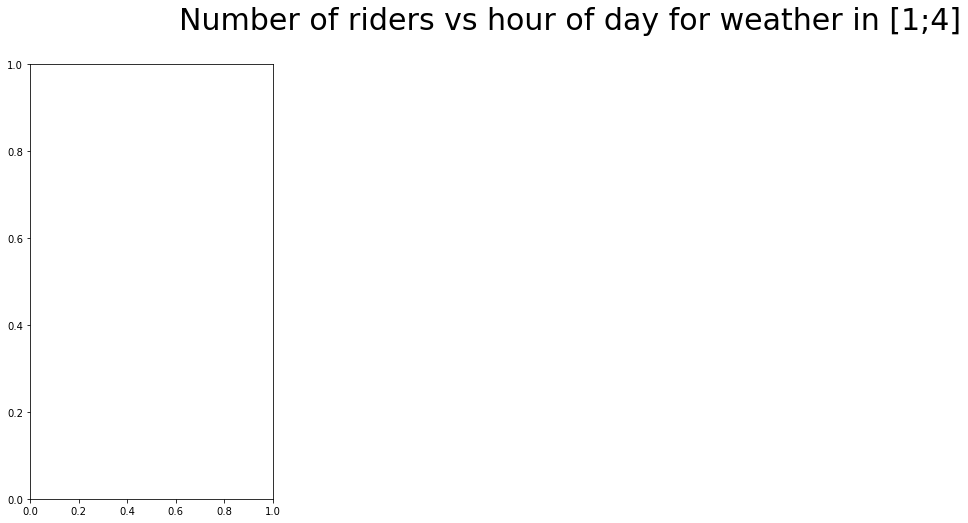

In [185]:
# Your code here
plt.figure(figsize=(20,8))
plt.suptitle("Number of riders vs hour of day for weather in [1;4]", size=30)
# plot for each weather type
for i in range(4):
    plt.subplot(1,4,i+1) # sharey=True
# slice by weather type, group according to hour, and
# aggregate by taking the mean
    temp_df = bikes_df[bikes_df.weather == (i+1)].groupby("hour").agg(['mean'])
# plotting the graph
    plt.plot(temp_df.index, temp_df.casual)
    plt.plot(temp_df.index, temp_df.registered)
# styling the graph
    plt.title("weather = {}".format(i+1), size=20)
    if i < 1:
        plt.ylabel("Avg. number of riders", size=20)
        yticks_temp = plt.yticks()[0]
    else:
        plt.yticks(yticks_temp[1:-1])
    plt.xlabel("Hour of the day", size=20)
    plt.legend(["Casual", "Registered"]);

## Answer
The impact of the weather1 and weather2 on the average number of rides is very less. There is a sudden change for weather3 when compared to weather 2, the average number of rides has decreased for both registered and casual rides.The impact of weather4 is huge on the average number of riders when compared to weather1, weather2, and weather3.
